In [18]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
sys.path.insert(0, '../../../sample_scripts/')
import glob
import warnings
warnings.filterwarnings("ignore")

# from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:0'

plt.rcParams["savefig.bbox"] = 'tight'

from importlib import reload
sys.path.insert(0, '../../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

def show(imgs, size=17):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(size, size))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

def gen_shadow_mask_vert(ld, depth_grid, depth_grid_blur=None, up_rate=1):
    ray = ld.view(3)
    ray[2] *= 0.5

    if depth_grid_blur is not None:
        depth_grid_for_test = depth_grid_blur.clone().to(ray.device)
        depth_grid_for_test = depth_grid_for_test.type_as(depth_grid)
        depth_grid_for_test[:, :, 2] *= (256 * up_rate)
        depth_grid[:, :, 2] *= (256 * up_rate)
        shadow_mask = th.clone(depth_grid[:, :, 2])
    else:
        depth_grid_for_test = depth_grid.clone().to(ray.device)
        depth_grid_for_test[:, :, 2] *= (256 * up_rate)
        depth_grid[:, :, 2] *= (256 * up_rate)
        shadow_mask = th.clone(depth_grid[:, :, 2])

    n = 256 * up_rate
    ray = ray / th.norm(ray)
    mxaxis = max(abs(ray[0]), abs(ray[1]))
    shift = ray / mxaxis * th.arange(n).view(n, 1)
    coords = depth_grid_for_test.view(1, n, n, 3) + shift.view(n, 1, 1, 3)

    output = th.nn.functional.grid_sample(
      th.tensor(np.tile(depth_grid_for_test[:, :, 2].view(1, 1, n, n), [n, 1, 1, 1])),
      coords[..., :2] / (n - 1) * 2 - 1,
      align_corners=True)
    diff = coords[..., 2] - output[:, 0] 
    shadow_mask *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
    
    return shadow_mask

def sh_to_ld(sh):
    
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    # print("[#] SH : ", sh)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    # print("[#] Light direction : ", ld)
    return ld

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width + img_width/4, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width + img_width/4, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image


In [2]:

ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
cfg.img_model.image_size = 256
# Load dataset
dataset = 'ffhq'
set_ = 'valid'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
# Load dataset
if dataset == 'itw':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ITW/itw_images_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ITW/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'ITW'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/itw_images_aligned/'
elif dataset == 'ffhq':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
    img_ext = '.jpg'
    cfg.dataset.training_data = 'ffhq_256_with_anno'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
elif dataset in ['mp_valid', 'mp_test', 'mp_test2']:
    if dataset == 'mp_test':
        sub_f = '/MultiPIE_testset/'
    elif dataset == 'mp_test2':
        sub_f = '/MultiPIE_testset2/'
    elif dataset == 'mp_valid':
        sub_f = '/MultiPIE_validset/'
    else: raise ValueError
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/params/"
    img_ext = '.png'
    cfg.dataset.training_data = f'/MultiPIE/{sub_f}/'
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise ValueError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_=set_,
    cfg=cfg,
)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = True 
deca = DECA(config = deca_cfg, device='cuda', mode='shape', mask=mask)

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])#, '60182.jpg'])
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg', '60000.jpg', '60001.jpg', '60002.jpg', '60004.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=1)
                            
dat, model_kwargs = next(iter(subset_loader))
print(model_kwargs.keys())
rendered_image, orig_visdict, orig_opdict = params_utils.render_deca_return_all(deca_params=model_kwargs, 
                                                        idx=0, n=len(img_idx), 
                                                        useTex=True, extractTex=True, 
                                                        deca_mode='', use_detail=True, mask=mask, repeat=False, 
                                                        deca_obj=deca)
print(orig_visdict.keys())
print(orig_opdict.keys())


[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml')

[#] Load data of valid from path...
1. Face segment dir :  /data/mint/DPM_Dataset//ffhq_256_with_anno/face_segment/
2. Deca rendered dir :  /data/mint/DPM_Dataset//ffhq_256_with_anno/rendered_images/
3. Shadow diff dir :  /data/mint/DPM_Dataset//ffhq_256_with_anno/shadow_diff/


Loading deca params...: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead']
DPM Image condition :  [None]
creating the FLAME Decoder
trained model found. load /home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/cond_utils/DECA/data/deca_model.tar
USING STARDARD...
/home/mint/Dev/DiFaReli/difareli-faster/experiment_scripts/TPAMI/anti_aliasing/../../../sample_scripts/cond_utils/DECA/decalib/utils
[#] DECA : SRenderY applied mask
dict_keys(['deca_masked_face_images_woclip_img', 'faceseg_nohead_img', 'faceseg_nohead_mask', 'cond_params', 'shadow', 'shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'tform', 'albedo', 'detail', 'image_name', 'raw_image', 'raw_image_path', 'image'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images', 'albedo_images', 'normal_images', 'rendered

# Smooth the depth map

In [49]:
def render_shadow_mask(sh_light, cam, verts, deca, axis_1=False, up_rate=1, smooth_depth=False, perturb_ld=False, perturb_dict=None, device='cuda', org_h=128, org_w=128):
    sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    from decalib.utils import util
    import cv2, tqdm
    
    shadow_mask_all = []
    if verts.shape[0] >= 2:
        tmp = []
        for i in range(1, verts.shape[0]):
            tmp.append(th.allclose(verts[[0]], verts[[i]]))
        assert all(tmp)
        
    depth_image, _ = deca.render.render_depth(verts.cuda(), up_rate=up_rate)   # Depth : B x 1 x H x W
    # print("[#] Depth Image : ", depth_image.shape)
    B, C, h, w = depth_image.shape

    depth_image_smooth = depth_image.detach().clone().cpu().numpy()
    depth_image_smooth = th.tensor(cv2.bilateralFilter(depth_image_smooth[0, 0, ...], d=9, sigmaColor=256, sigmaSpace=256))
    depth_image_smooth = depth_image_smooth[None, None, ...]
    assert depth_image_smooth.shape == depth_image.shape

    # plt.imshow(depth_image[0, 0].cpu().numpy().squeeze(), cmap='gray')
    # plt.show()
    # plt.imshow(depth_image_smooth, cmap='gray')
    # plt.show()
    # assert False

    depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
    depth_grid = np.stack((depth_grid), axis=-1)[None, ...]   # 1 x H x W x 2

    if smooth_depth:
        depth_grid = np.concatenate((depth_grid, depth_image_smooth.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3
    else:
        depth_grid = np.concatenate((depth_grid, depth_image.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3

    depth_grid[..., 2] *= (256 * up_rate)
    depth_grid = th.tensor(depth_grid).to(device)
    shadow_mask = th.clone((depth_image.permute(0, 2, 3, 1)[:, :, :, 0]) * 256 * up_rate).to(device)

    out_shadow_mask = []
    for i in tqdm.tqdm(range(sh_light.shape[0]), position=0, desc="Rendering Shadow Mask on each Sh..."):
        #NOTE: Render the shadow mask from light direction
        ld = sh_to_ld(sh=th.tensor(sh_light[[i]]))
        ld = util.batch_orth_proj(ld[None, ...].cuda(), cam[None, ...].cuda());     # This fn takes pts=Bx3, cam=Bx3
        ld[:, :, 1:] = -ld[:, :, 1:]

        if perturb_ld:
            ld_to_cast = []
            for eps_pt in np.linspace(-perturb_dict['eps'], perturb_dict['eps'], perturb_dict['dense']):
                ld_to_cast.append(ld.clone() + eps_pt)
        else:
            ld_to_cast = [ld]

        perturb_out = []
        # print("[#] Render each perturbed light direction...")
        for ld_i in tqdm.tqdm(ld_to_cast, position=1, leave=False, desc="Rendering each perturbed light direction..."):

            ray = ld_i.view(3).to(device)

            if axis_1:
                ray[1] *= -1    # This for jst temporarly fix the axis 1 which the shading is bright in the middle, but the light direction is back of the head
            ray[2] *= 0.5
            n = 256 * up_rate
            ray = ray / th.norm(ray)
            mxaxis = max(abs(ray[0]), abs(ray[1]))
            shift = ray / mxaxis * th.arange(n).view(n, 1).to(device)

            each_depth_grid = depth_grid[0].clone()
            coords = each_depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)

            output = th.nn.functional.grid_sample(
                th.tensor(np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1])).to(device),
                coords[..., :2] / (n - 1) * 2 - 1,
                align_corners=True)
            diff = coords[..., 2] - output[:, 0] 
            tmp = shadow_mask.clone() * ((th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5)   # output is in 1 x H x W
            # tmp = th.clip(tmp, 0, 255.0) / (256 * up_rate)
            tmp = th.clip(tmp, 0, (256*up_rate)) / (256 * up_rate)
            perturb_out.append(tmp)

        perturb_out = th.cat(perturb_out, dim=0)
        # print("[#] Perturb Out : ", perturb_out.shape)
        out_sd = th.mean(perturb_out, dim=0, keepdim=True)
        # print("[#] Out SD : ", out_sd.shape)

        if up_rate > 1:
            out_sd = cv2.resize(out_sd.permute(1, 2, 0).cpu().numpy(), (org_h, org_w), interpolation=cv2.INTER_AREA)[..., None]
        else:
            out_sd = out_sd.permute(1, 2, 0).cpu().numpy()
        out_shadow_mask.append(th.tensor(out_sd).to(device))

        
    
    print(shadow_mask.max(), shadow_mask.min())
        
    return out_shadow_mask


# Single light source

In [ ]:
shadow_mask = render_shadow_mask(
                                sh_light=model_kwargs['light'], 
                                cam=model_kwargs['cam'][0],
                                verts=orig_visdict['trans_verts_orig'], 
                                deca=deca, 
                                device='cpu',
                                up_rate=2,
                                smooth_depth=True,
                                perturb_ld=True,
                                org_h=256, org_w=256)

print("[#] Shadow Mask: ", len(shadow_mask))
# print("Min: ", shadow_mask.min(), "Max: ", shadow_mask.max(), "Unq: ", th.unique(shadow_mask))
for sm in shadow_mask:
    print("[#] Min: ", sm.min(), "Max: ", sm.max(), "Unq: ", th.unique(sm), "Shape: ", sm.shape)

plt.imshow(create_image_grid(shadow_mask, n_rows=1), cmap='gray')
plt.show()
# plt.imshow(shadow_mask[0].cpu().numpy(), cmap='gray')
# plt.show()

# Interpolate light source

Rendering Shadow Mask on each Sh...: 100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


tensor(255.9161) tensor(0.)
[#] Shadow Mask:  10
[#] Min:  tensor(0.) Max:  tensor(0.9997) Unq:  tensor([0.0000, 0.2644, 0.2681,  ..., 0.9995, 0.9995, 0.9997]) Shape:  torch.Size([256, 256, 1])
[#] Min:  tensor(0.) Max:  tensor(0.9997) Unq:  tensor([0.0000, 0.2644, 0.2681,  ..., 0.9995, 0.9995, 0.9997]) Shape:  torch.Size([256, 256, 1])
[#] Min:  tensor(0.) Max:  tensor(0.9997) Unq:  tensor([0.0000, 0.2644, 0.2681,  ..., 0.9995, 0.9995, 0.9997]) Shape:  torch.Size([256, 256, 1])
[#] Min:  tensor(0.) Max:  tensor(0.9997) Unq:  tensor([0.0000, 0.2644, 0.2681,  ..., 0.9995, 0.9995, 0.9997]) Shape:  torch.Size([256, 256, 1])
[#] Min:  tensor(0.) Max:  tensor(0.9997) Unq:  tensor([0.0000, 0.2644, 0.2681,  ..., 0.9995, 0.9995, 0.9997]) Shape:  torch.Size([256, 256, 1])
[#] Min:  tensor(0.) Max:  tensor(0.9997) Unq:  tensor([0.0000, 0.2793, 0.2802,  ..., 0.9995, 0.9995, 0.9997]) Shape:  torch.Size([256, 256, 1])
[#] Min:  tensor(0.) Max:  tensor(0.9997) Unq:  tensor([0.0000, 0.2793, 0.2802,  

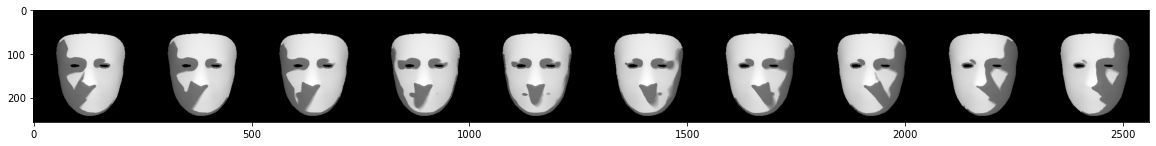

In [52]:
tgt_light = '4.1208167 4.113482 4.119587 -0.35264063 -0.38354635 -0.3695604 0.22570051 0.23566791 0.2297648 -0.46458092 -0.48861718 -0.47885132 -0.31964195 -0.3250893 -0.32510865 -0.03330686 -0.05441852 -0.047533773 0.5244178 0.5305497 0.52580774 -0.10181245 -0.107420176 -0.10384175 0.097432286 0.091219686 0.09322698'
tgt_light = np.array([float(i) for i in tgt_light.split()]).reshape(1, -1)

sh_light = np.linspace(0, 1, 10)[..., None]
sh_light = model_kwargs['light'] * (1 - sh_light) + tgt_light * sh_light
# print(sh_light.shape)
# assert False

shadow_mask = render_shadow_mask(
                                sh_light=sh_light, 
                                cam=model_kwargs['cam'][0],
                                verts=orig_visdict['trans_verts_orig'], 
                                deca=deca, 
                                device='cpu',
                                up_rate=1,
                                smooth_depth=True,
                                perturb_ld=True,
                                perturb_dict={'eps':0.25, 'dense':20},
                                org_h=256, org_w=256)

print("[#] Shadow Mask: ", len(shadow_mask))
for sm in shadow_mask:
    print("[#] Min: ", sm.min(), "Max: ", sm.max(), "Unq: ", th.unique(sm), "Shape: ", sm.shape)

fig = plt.figure(figsize=(20, 10))
plt.imshow(create_image_grid(shadow_mask, n_rows=1), cmap='gray')
plt.show()
import torchvision
os.makedirs('./shadow_mask', exist_ok=True)
torchvision.io.write_video("./shadow_mask/shadow_mask_noAA.mp4", th.tensor(np.repeat(np.stack(shadow_mask)*255., repeats=3, axis=-1)), fps=15)